## FC for Widespread Pain Subjects
#### Input: *stc.mat
####  Output: con, visualization

In [1]:
import os
from pathlib import Path
import sys
sys.path.append("/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/")
from eeg_toolkit import preprocess, utils
import eeg_toolkit.functional_connectivity as fc

0 files missing from root.txt in /home/wanglab/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage


In [2]:
# Settings
times_tup, time_win_path = preprocess.get_time_window(5)

# data paths
data_dir = Path("../../Data")
processed_data_path = data_dir / "Processed Data"
stc_path = data_dir / "Source Time Courses"
EO_resting_data_path = stc_path / "Eyes Open"
EC_resting_data_path = stc_path / "Eyes Closed"
zscored_epochs_data_path = stc_path / "zscored_Epochs" / time_win_path

# save paths
fc_path = data_dir / "Functional Connectivity"

[-2.5,0.0,2.5]


In [3]:
# viable subjects
sub_ids = utils.import_subs(data_dir, "sub_ids.txt")
sub_ids = sub_ids[7:]  # select only 64ch subs and turn into set
# print(sub_ids)

# TODO: replace these subs, temporarility removed just for grant figures
TEMP_EXCLUDE = [
    # Chronic Pain Subjects
    '018', '024', '030', '031', '033', '034', '037', 
    '038', '040', '045', '049', '052', '054', '057', '058',
    # Control Subjects
    'C5.', 'C6.', 'C7.', 'C8.', 'C9.', 'C12', 'C13',
    'C14', 'C16', 'C18', 'C19', 'C20', 'C21', 'C24', 'C26'
    ]
# TODO: figure out why these have NaNs
NAN_SUBS = ['018','021','C1.','C2.','C3.']
# TODO: temporarily remove subjects with no key presses
NO_KEYPRESS = ['045', 'C1.', 'C5.', 'C8.', 'C20', 'C21', 'C22']

sub_ids = [sub for sub in sub_ids if sub not in TEMP_EXCLUDE]
sub_ids = [sub for sub in sub_ids if sub not in NAN_SUBS]
sub_ids = [sub for sub in sub_ids if sub not in NO_KEYPRESS]
print(sub_ids)

['020', '022', '023', '027', '029', '032', '035', '036', '039', '041', '042', '043', '044', '046', '048', '050', '051', '053', '055', '056', 'C10', 'C11', 'C15', 'C17', 'C25', 'C27']


In [4]:
sub_ids_CP = [el for el in sub_ids if el.startswith('0')]
sub_ids_HC = [el for el in sub_ids if el.startswith('C')]

print(f"Chronics: {len(sub_ids_CP)}")
print(f"Controls: {len(sub_ids_HC)}")
print(f"Total: {len(sub_ids)}")

Chronics: 20
Controls: 6
Total: 26


In [5]:
# Get stc only from selected labels
roi_names = [  # Left
    "rostralanteriorcingulate-lh",  # Left Rostral ACC
    "caudalanteriorcingulate-lh",  # Left Caudal ACC
    "postcentral-lh",  # Left S1,
    "insula-lh",
    "superiorfrontal-lh",  # Left Insula, Left DL-PFC,
    "medialorbitofrontal-lh",  # Left Medial-OFC
    # Right
    "rostralanteriorcingulate-rh",  # Right Rostral ACC
    "caudalanteriorcingulate-rh",  # Right Caudal ACC
    "postcentral-rh",  # , Right S1
    "insula-rh",
    "superiorfrontal-rh",  # Right Insula, Right DL-PFC
    "medialorbitofrontal-rh",
]  # Right Medial-OFC

Freq_Bands = {
    'delta': [0, 4],
    "theta": [4.0, 8.0],
    # "alpha": [8.0, 13.0],
    "beta": [13.0, 30.0],
    "low-gamma": [30.0, 58.5],
    # "notch": [58.5, 61.5],
    "high-gamma": [61.5, 100.0],
}
band_names = [band for band in Freq_Bands]

sfreq = 400  # Hz
tmin, tmax = 0.0, 1.5  # exclude the baseline period for connectivity estimation

# TODO: replace con methods and conditions once testing complete
con_methods = [
  "wpli2_debiased",
  "dpli",
  "plv",
]

# Include intermediate stimulus?
include_LS = False

conditions = (
    [
        "Hand NS",
        "Hand LS",
        "Hand HS",
        "Back NS",
        "Back LS",
        "Back HS",
        "Eyes Open",
        "Eyes Closed",
    ]
    if include_LS
    else [
        "Hand NS",
        # 'Hand LS',
        "Hand HS",
        # "Back NS",
        # 'Back LS',
        # "Back HS",
        # "Eyes Open",
        # "Eyes Closed",
    ]
)

groups=['Chronic Pain', 'Healthy Control']

In [6]:
# Compute the average connectivity for each subject in the Chronic Pain
sub_con_CP = {}
for sub_id in sub_ids_CP:
    print(sub_id)
    sub_avg_cons = fc.compute_sub_avg_con(
        sub_id,
        "Chronic Pain",
        processed_data_path,
        zscored_epochs_data_path,
        EO_resting_data_path,
        EC_resting_data_path,
        con_methods,
        conditions,
        roi_names,
        Freq_Bands,
        tmin,
        tmax,
        sfreq,
        include_LS=include_LS,
    )
    sub_con_CP[sub_id] = sub_avg_cons
    break


020
Reading stimulus labels and pain ratings for Subject 020...

*stim_labels length = 80*
*pain_ratings_raw length = 80*

+----------------+----------------+
| Subject        | 020            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 20             |
+----------------+----------------+
| Band           | delta          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 0.0Hz..4.0Hz (5 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral densi

/home/wanglab/mambaforge/envs/mne/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 1.002 sec, need at least inf sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 020            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 20             |
+----------------+----------------+
| Band           | beta           |
+----------------+----------------+
| Method         | wpli2_debiased |
+--------------

/home/wanglab/mambaforge/envs/mne/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 1.002 sec, need at least inf sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | 020            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 20             |
+----------

/home/wanglab/mambaforge/envs/mne/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 1.002 sec, need at least inf sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+---------+
| Subject        | 020     |
+----------------+---------+
| Condition      | Hand NS |
+------------

/home/wanglab/mambaforge/envs/mne/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 1.002 sec, need at least inf sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+---------+
| Subject        | 020     |
+----------------+---------+
| Condition      | Hand HS |
+----------------+---------+
| Num. of epochs | 20      |
+----------------+---------+
| Band           | beta    |
+----------------+---------+
| Method         | dpli    |
+----------------+---------+
Connec

/home/wanglab/mambaforge/envs/mne/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 1.002 sec, need at least inf sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+---------+
| Subject        | 020     |
+----------------+---------+
| Condition      | Hand NS |
+------------

/home/wanglab/mambaforge/envs/mne/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 1.002 sec, need at least inf sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+---------+
| 

In [7]:
# Repeat for the Healthy Control group
sub_con_HC = {}
for sub_id in sub_ids_HC:
    print(sub_id)
    sub_avg_cons = fc.compute_sub_avg_con(
        sub_id,
        "Healthy Control",
        processed_data_path,
        zscored_epochs_data_path,
        EO_resting_data_path,
        EC_resting_data_path,
        con_methods,
        conditions,
        roi_names,
        Freq_Bands,
        tmin,
        tmax,
        sfreq,
        include_LS=include_LS,
    )
    sub_con_HC[sub_id] = sub_avg_cons
    break


C10
Reading stimulus labels and pain ratings for Subject C10...

*stim_labels length = 57*
*pain_ratings_raw length = 57*

+----------------+----------------+
| Subject        | C10            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | delta          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 0.0Hz..4.0Hz (5 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral densi

/home/wanglab/mambaforge/envs/mne/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 1.002 sec, need at least inf sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C10            |
+----------------+----------------+
| Condition      | Hand NS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | low-gamma      |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.

/home/wanglab/mambaforge/envs/mne/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 1.002 sec, need at least inf sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+----------------+
| Subject        | C10            |
+----------------+----------------+
| Condition      | Hand HS        |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | low-gamma      |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computi

/home/wanglab/mambaforge/envs/mne/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 1.002 sec, need at least inf sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+-----------+
| Subject        | C10       |
+----------------+-----------+
| Condition      | Hand NS   |
+----------------+-----------+
| Num. of epochs | 10        |
+----------------+-----------+
| Band           | low-gamma |
+----------------+-----------+
| Method         | dpli      |
+----------------+-----------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 30.9Hz..57.9Hz (28 points)
    connectivity scores will be averaged for each band
    Using mul

/home/wanglab/mambaforge/envs/mne/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 1.002 sec, need at least inf sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+-----------+
| Subject        | C10       |
+----------------+-----------+
| Condition      | Hand HS   |
+----------------+-----------+
| Num. of epochs | 10        |
+----------------+-----------+
| Band           | low-gamma |
+----------------+-----------+
| Method         | dpli      |
+----------------+-----------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 30.9Hz..57.9Hz (28 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
 

/home/wanglab/mambaforge/envs/mne/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 1.002 sec, need at least inf sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+-----------+
| Subject        | C10       |
+----------------+-----------+
| Condition      | Hand NS   |
+----------------+-----------+
| Num. of epochs | 10        |
+----------------+-----------+
| Band           | low-gamma |
+----------------+-----------+
| Method         | plv       |
+----------------+-----------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing con

/home/wanglab/mambaforge/envs/mne/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 1.002 sec, need at least inf sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:153: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*con_data shape = (12, 12)*
+----------------+-----------+
| Subject        | C10       |
+----------------+-----------+
| Condition      | Hand HS   |
+----------------+-----------+
| Num. of epochs | 10        |
+----------------+-----------+
| Band           | low-gamma |
+----------------+-----------+
| Method         | plv       |
+----------------+-----------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 30.9Hz..57.9Hz (28 points)
    connectivity sc

In [8]:
# Compute the average connectivity across subjects in each group
group_con_CP = fc.compute_group_con(sub_con_CP, conditions, con_methods, band_names)
group_con_HC = fc.compute_group_con(sub_con_HC, conditions, con_methods, band_names)

In [9]:
# Save result as pickle
utils.pickle_data(fc_path, "sub_con_CP.pkl", sub_con_CP)
utils.pickle_data(fc_path, "sub_con_HC.pkl", sub_con_HC)

utils.pickle_data(fc_path, "group_con_CP.pkl", group_con_CP)
utils.pickle_data(fc_path, "group_con_HC.pkl", group_con_HC)

Saved sub_con_CP.pkl to ../../Data/Functional Connectivity.
Saved sub_con_HC.pkl to ../../Data/Functional Connectivity.
Saved group_con_CP.pkl to ../../Data/Functional Connectivity.
Saved group_con_HC.pkl to ../../Data/Functional Connectivity.


### Assess results

In [10]:
use_saved_data = True

if use_saved_data:
    group_con_CP = utils.unpickle_data(fc_path/"group_con_CP.pkl")
    group_con_HC = utils.unpickle_data(fc_path/"group_con_HC.pkl")

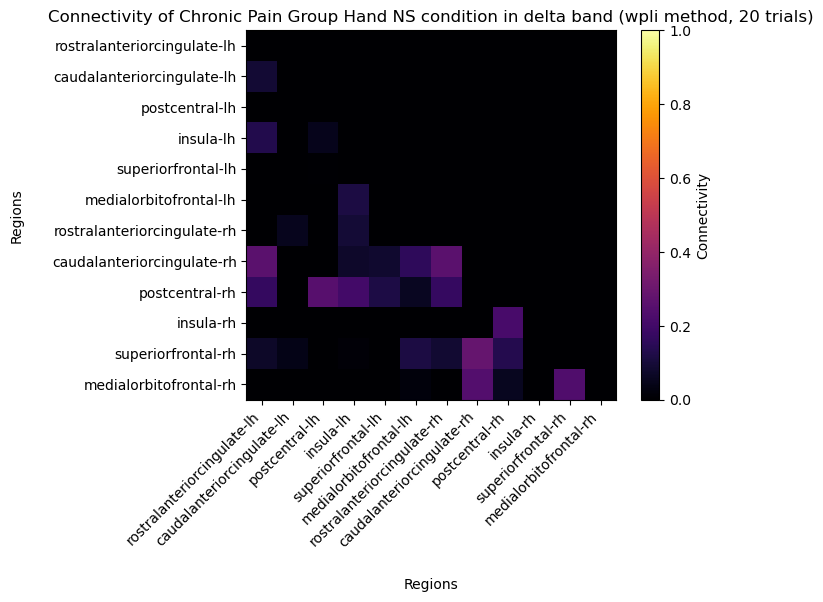

Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-d

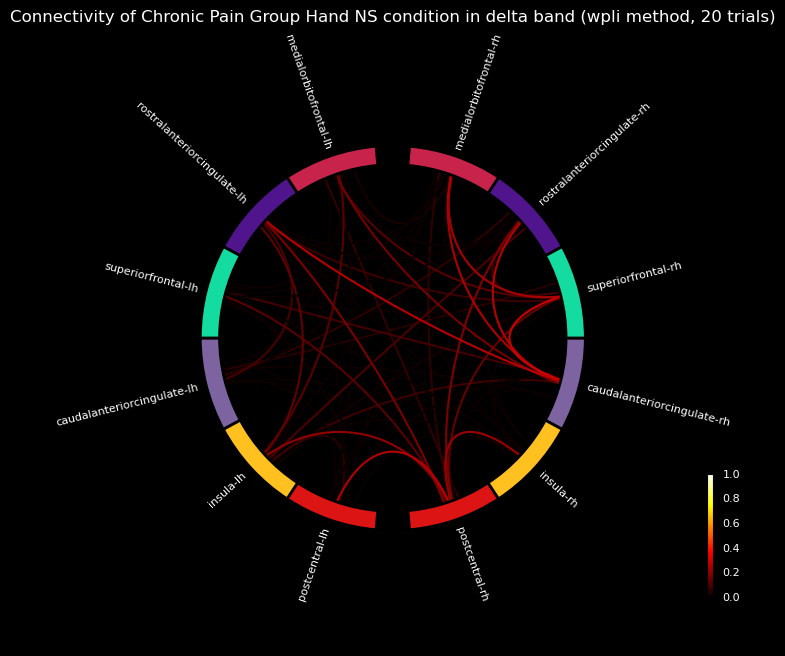

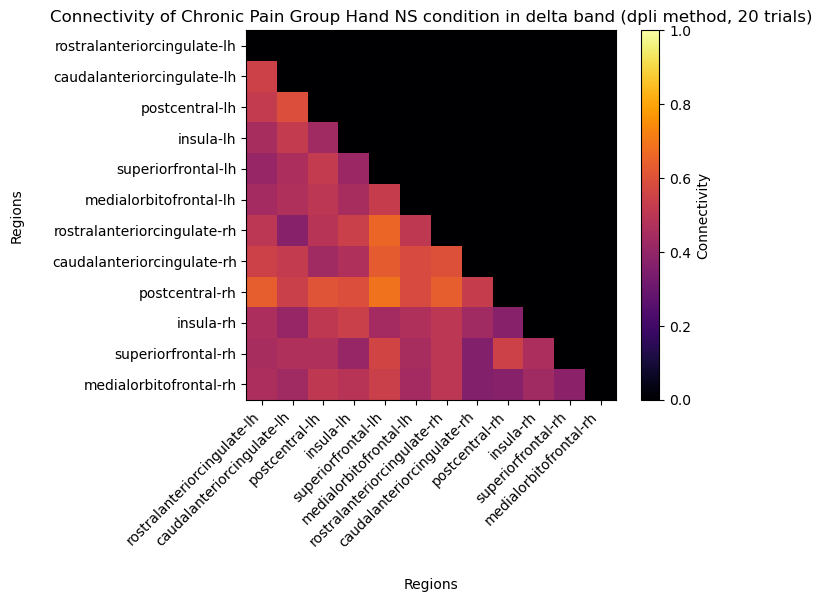

Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-d

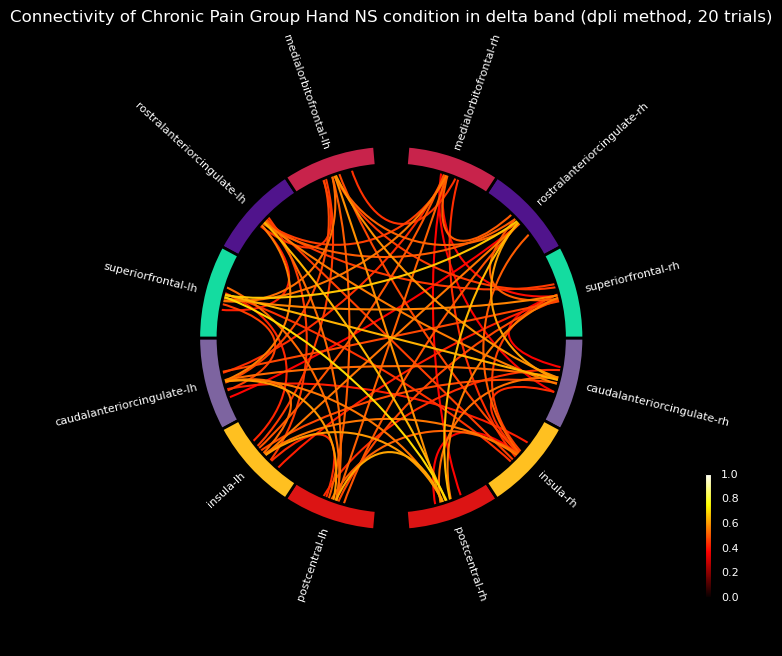

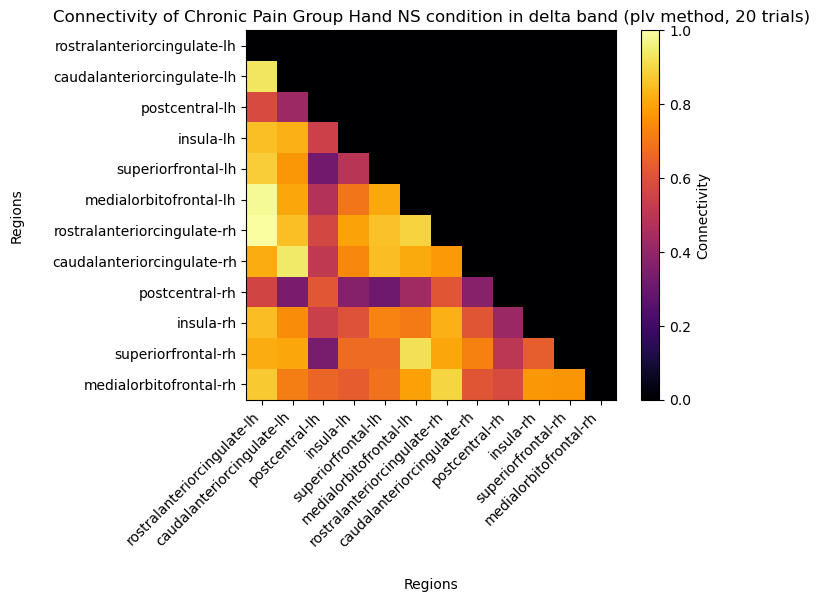

Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-d

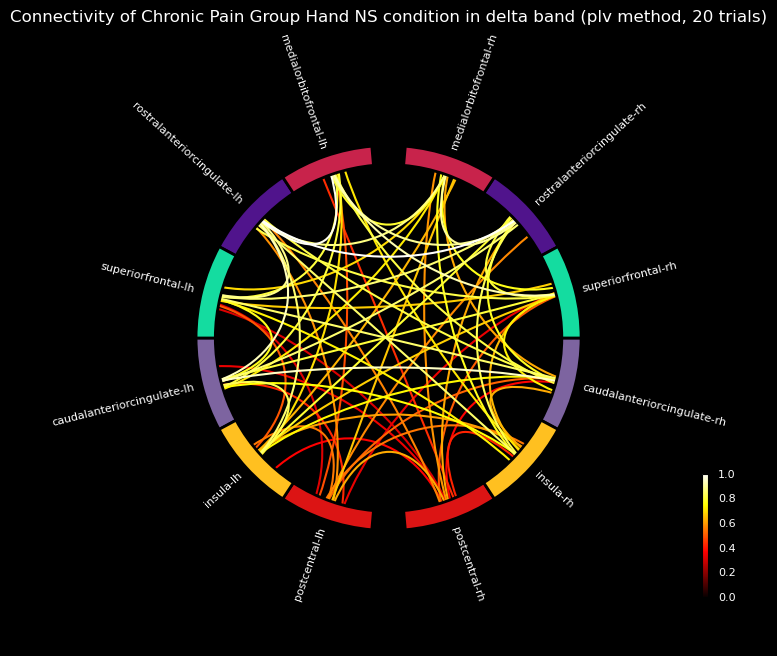

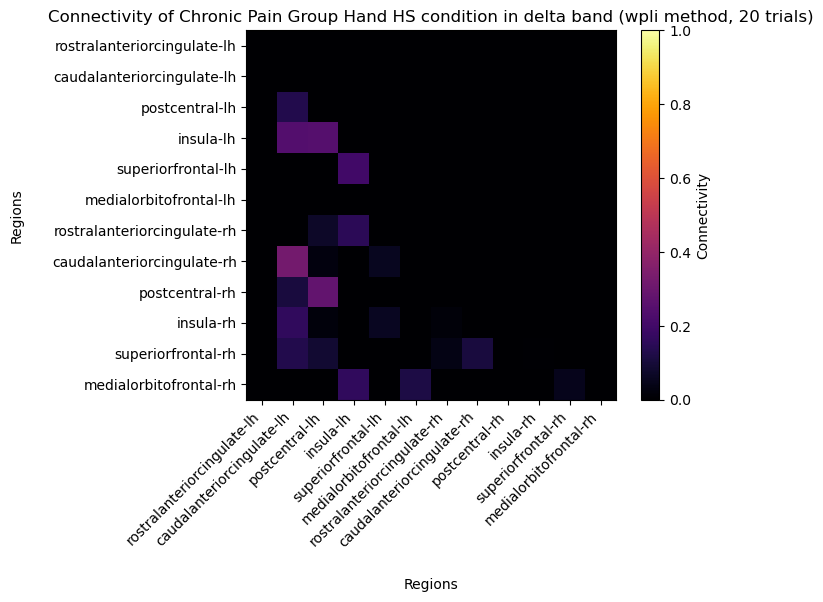

Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-d

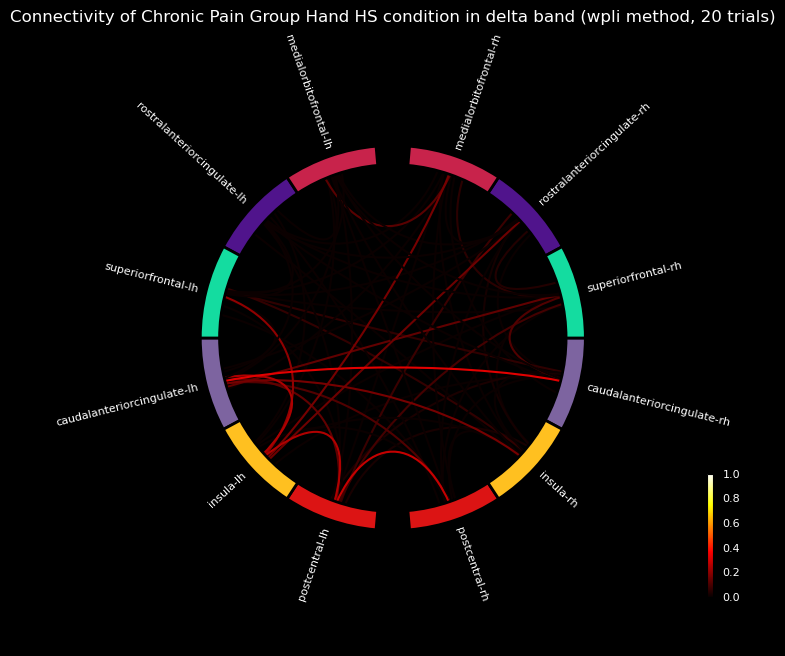

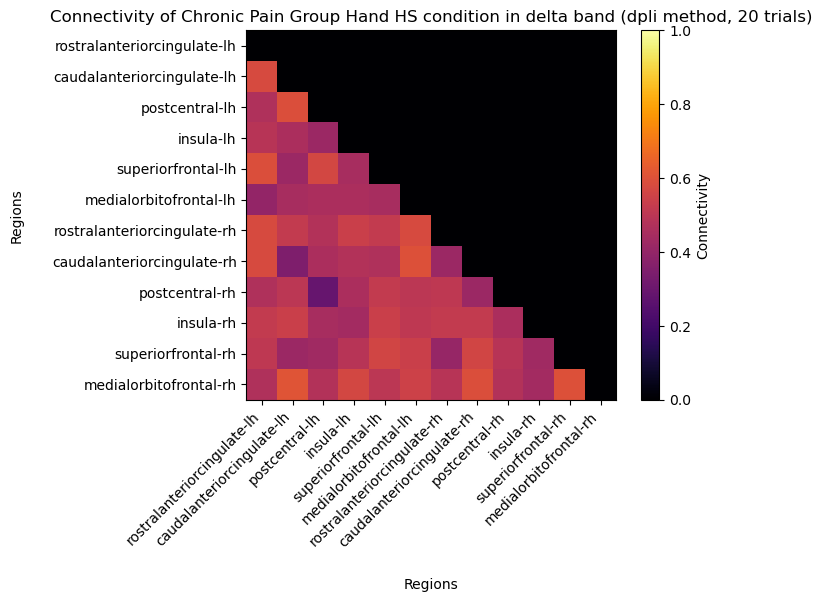

Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-d

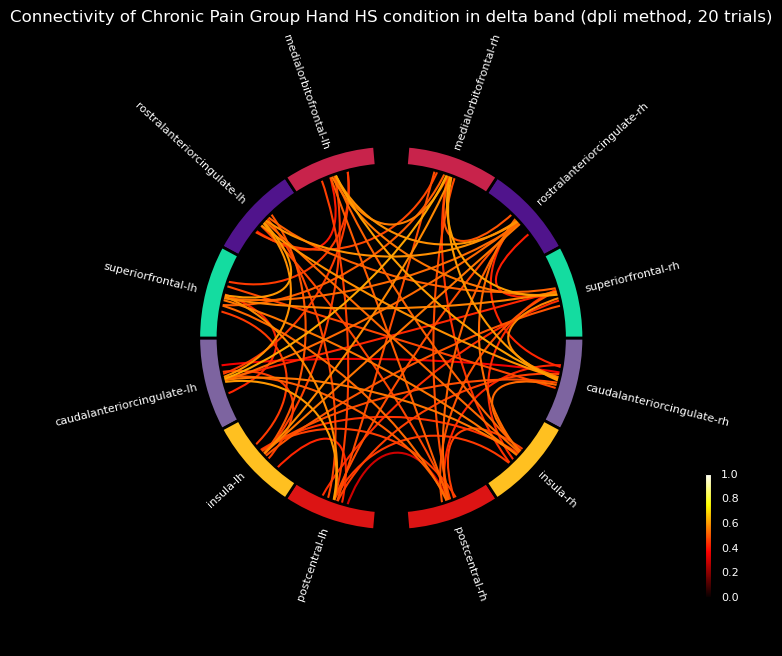

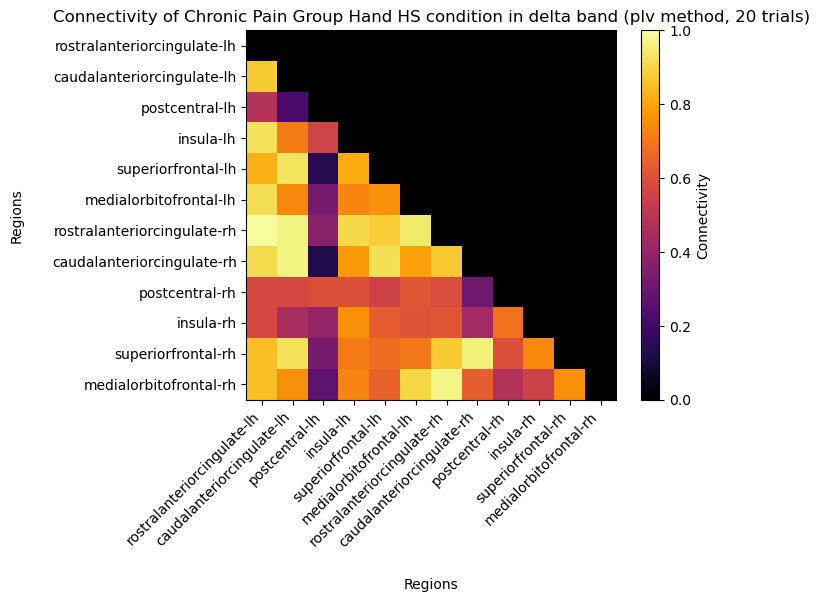

Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-d

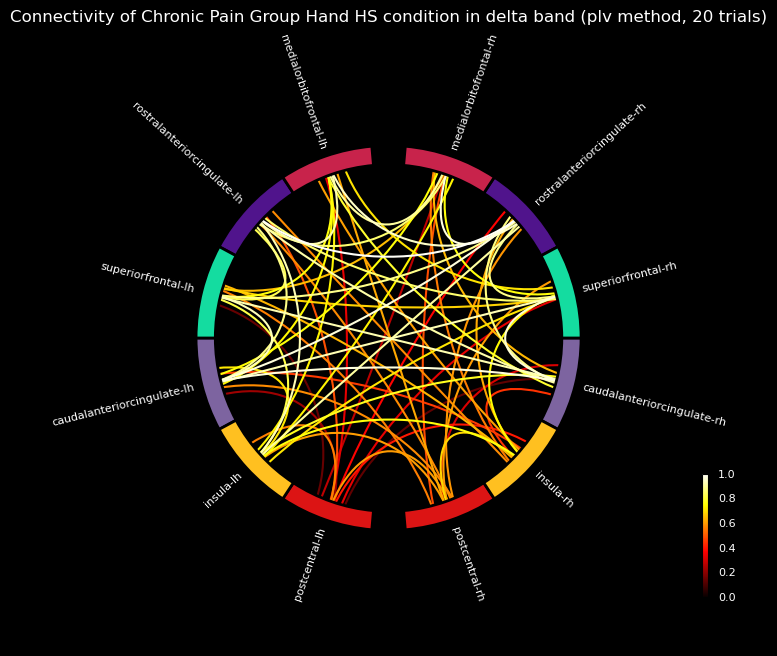

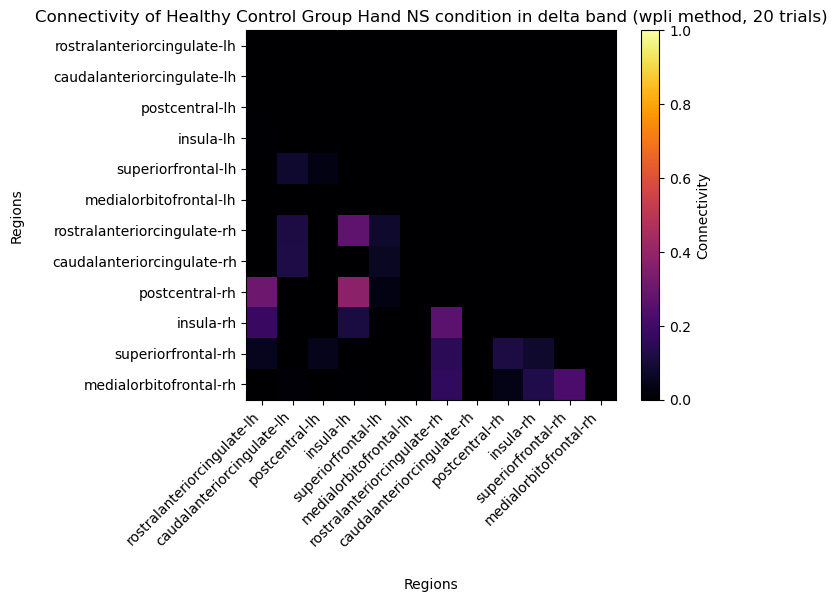

Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-d

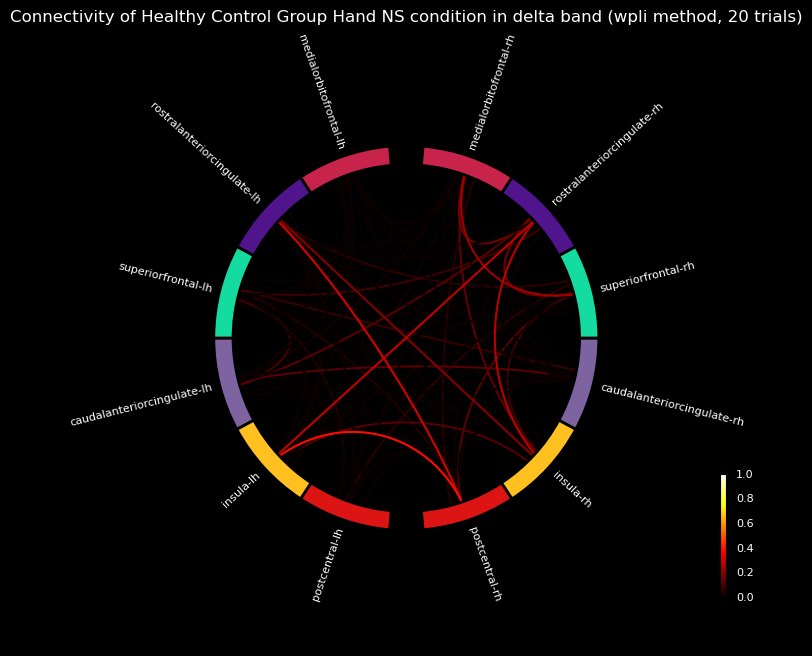

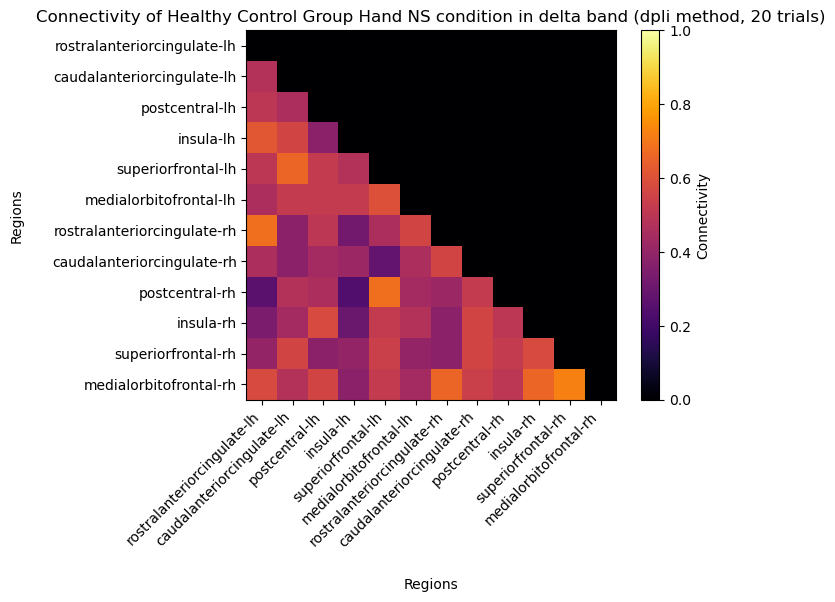

Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-d

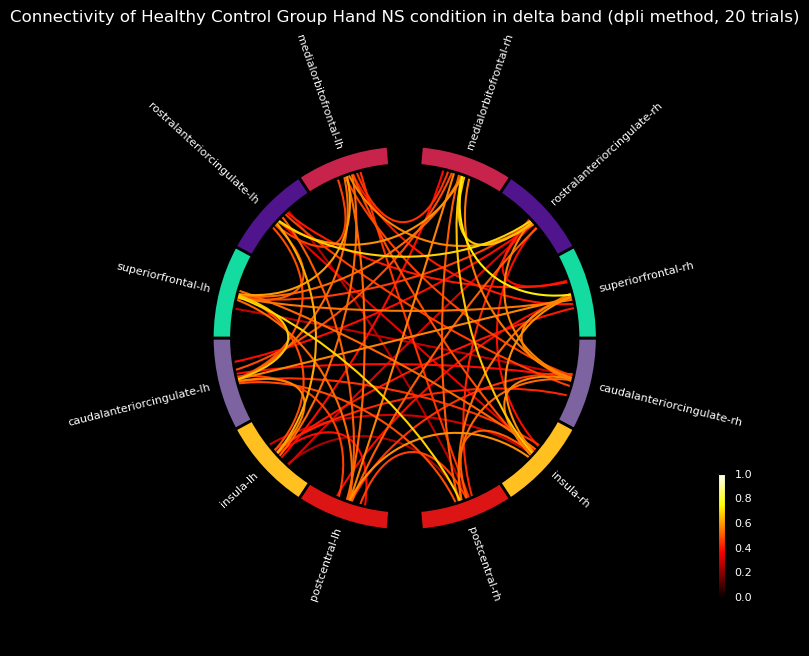

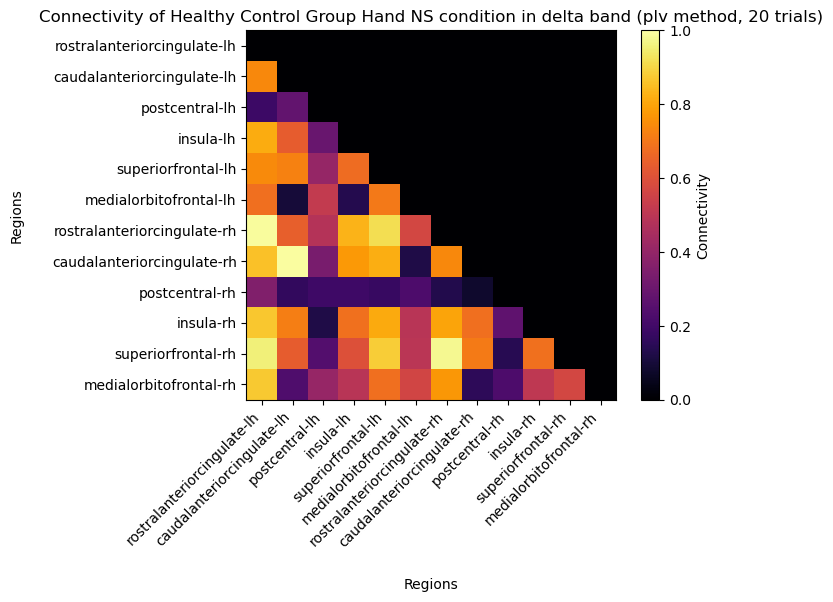

Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-d

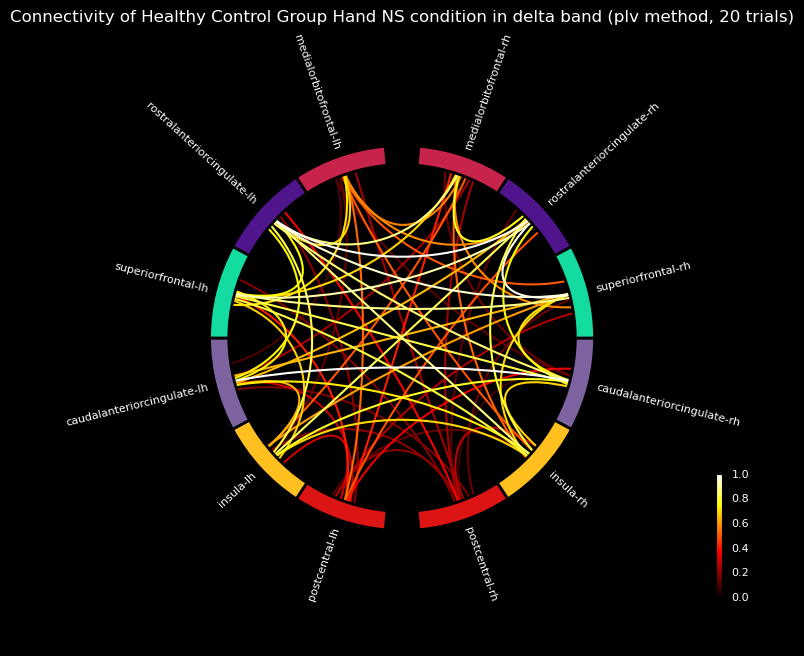

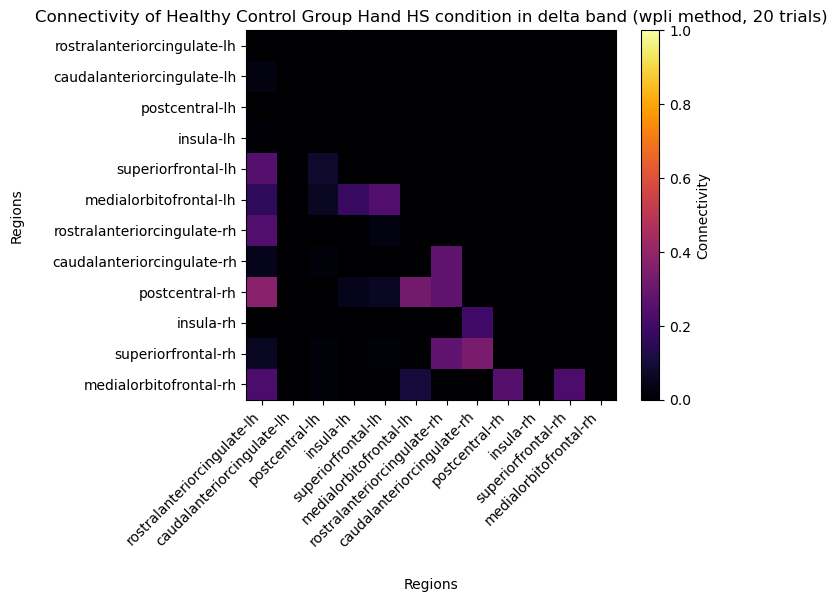

Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-d

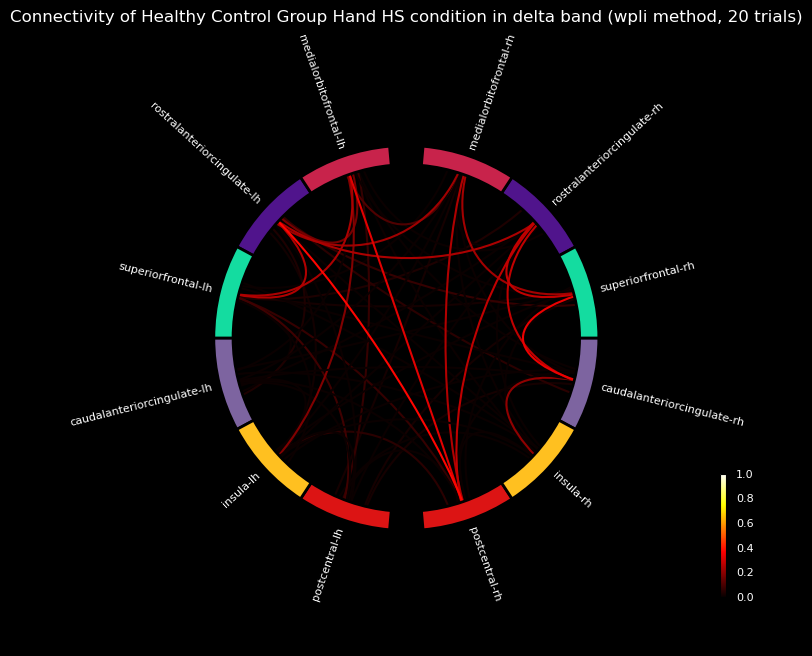

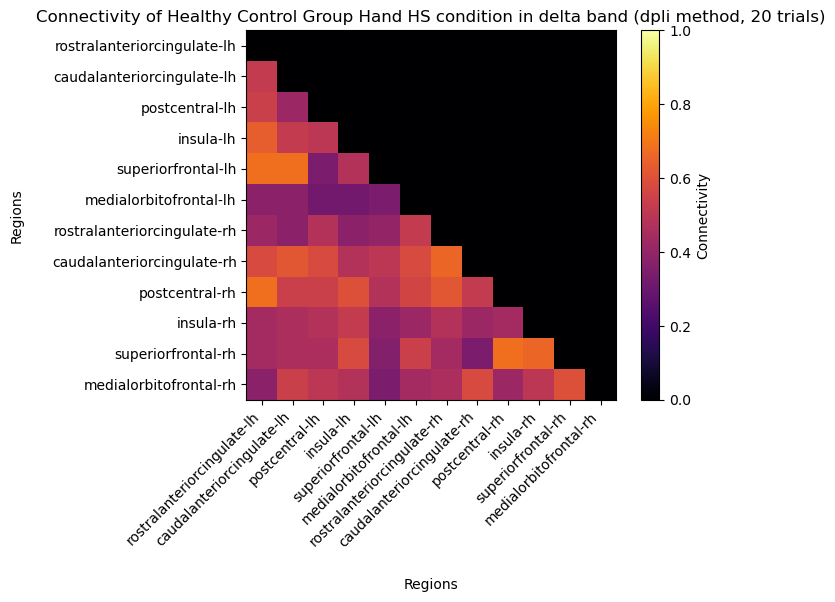

Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-d

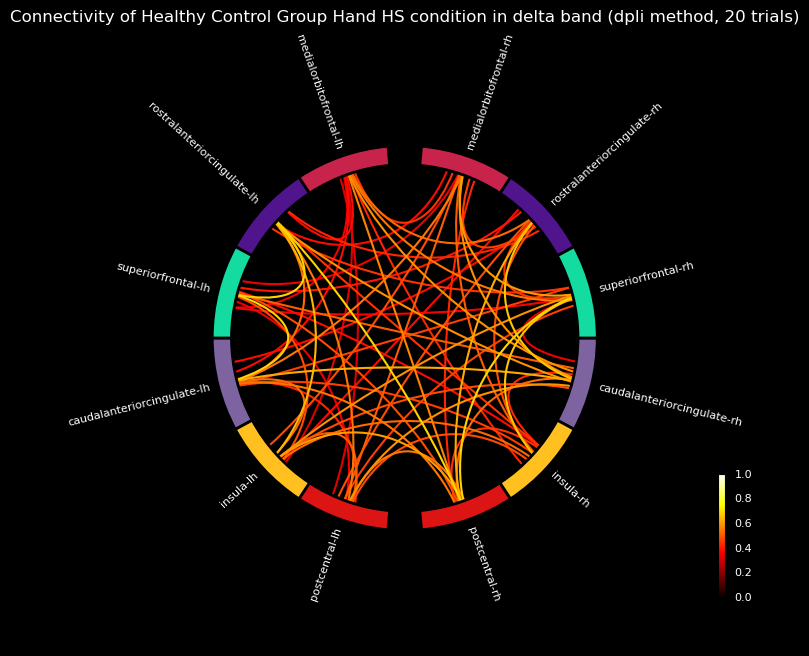

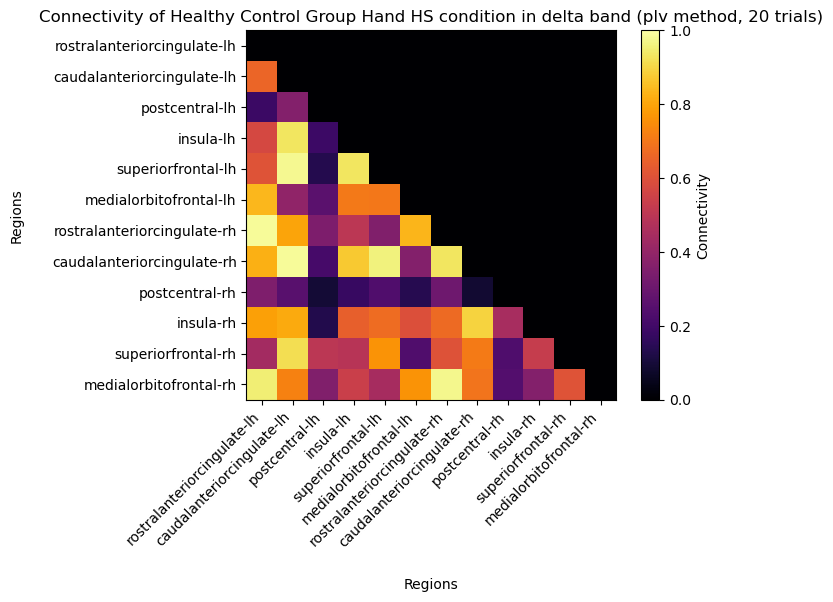

Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /home/wanglab/mne_data/MNE-fsaverage-d

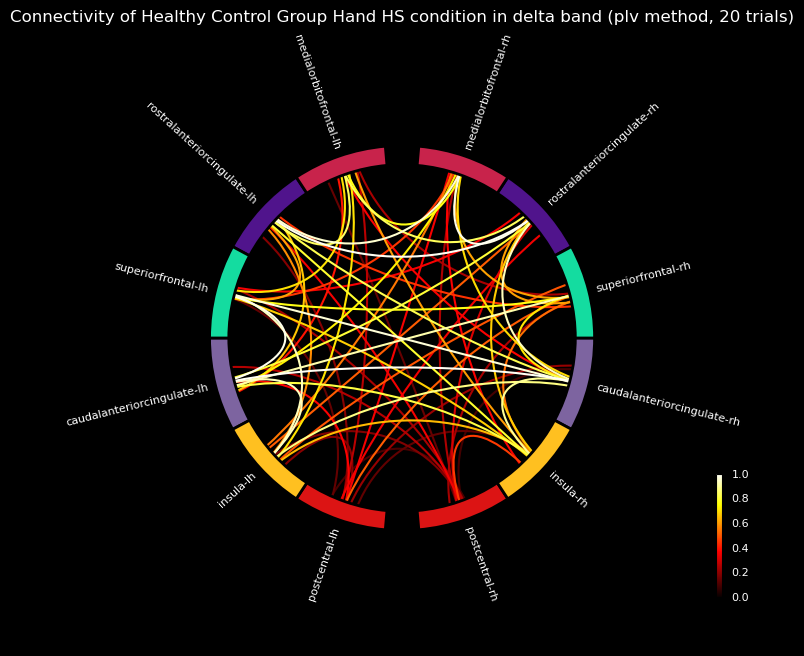

In [11]:
# Plot connectivity
for group, group_name in zip([group_con_CP, group_con_HC], groups):
    for condition in conditions:
        for method in con_methods:
            for band in band_names:
                num_epochs = group_con_CP[condition]['num_epochs']
                # Gather the information for plotting
                plot_kwargs= dict(
                    method=method, band=band, 
                    roi_names=roi_names,
                    group_name=group_name, condition=condition,
                    num_epochs=num_epochs)
    
                # Epochs
                con_data = group[condition][method][band]
                
                fc.plot_connectivity(con_data, **plot_kwargs, save_path=fc_path)
                fc.plot_connectivity_circle(con_data, **plot_kwargs, save_path=fc_path)
                
                break